# Playground to implement W&B as well as start hyperparameter-tuning

# WanDB

In [1]:
#%pip install wandb

In [1]:
import subprocess

import pandas

import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import os

In [3]:
subprocess.call(['wandb', 'login', '4e8d3dcb1584ad129b3b49ccc34f65b20116ae54'])

0

In [4]:
wandb.init(project='precursor_charge_multilabel')

wandb: Currently logged in as: nkopp (team-bioinf). Use `wandb login --relogin` to force relogin


## Setup

In [5]:
#%pip install seaborn

In [2]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
import keras

In [3]:
train_datapath = ["data/"+file for file in os.listdir('data') if file.endswith(".parquet")][0]
batch_size = 32

# Dataset batches + split

In [4]:
import re

def one_hot_precursor(int_value, charges=[1,2,3,4,5,6]):
    """
    One-hot encodes the precursor charge
    :param df: dataframe
    :param max_charge_included: int
    :return: dataframe
    """
    one_hot = [1 if x == int_value else 0 for x in charges]

    return one_hot

In [5]:
file_list = ["data/"+file for file in os.listdir('data') if file.endswith('.parquet')]
print(file_list[0])

data/Thermo_SRM_Pool_meta_data.parquet


### import parquet files, drop all columns we dont need for training, one-hot encode precursor charge, translate sequence

In [6]:
batches_parquet = dict()
counter = 0
for file in file_list:
    df = pd.read_parquet(file, engine='fastparquet')
    # drop all columns we dont need for training
    for column in df.columns:
        if column not in ["modified_sequence","precursor_intensity", "precursor_charge"]:
            df.drop(column, axis=1, inplace=True)
    df['parquet_file'] = file
    charge_ranges = [1, 2, 3, 4, 5, 6] # TODO SET RANGES
    df = df[df["precursor_charge"].isin(charge_ranges)] # remove 7+ charge states // only take charge states 2,3,4
    df = df.dropna(subset=['precursor_intensity']) # drop rows with no precursor intensity
    batches_parquet[file] = df
    counter += 1
    #if counter > 2:
        #break # TODO REMOVE BREAK FOR FIRST FILE IN LIST

In [7]:
vocabulary = []
vocabulary+=list('XACDEFGHIKLMNPQRSTVWY')
max_len_seq = 0

for df in batches_parquet.values():
    if max_len_seq < df['modified_sequence'].str.len().max():
        max_len_seq = df['modified_sequence'].str.len().max()
    annotations = re.findall(r'(\w\[UNIMOD:\d+\])', ' '.join(df['modified_sequence']))
    #annotations = re.findall(r'[A-Z]\[[^\]]*\]|.', ' '.join(df['modified_sequence']))
    for item in annotations:
        if item not in vocabulary:
                vocabulary.append(item)

In [8]:
print(vocabulary)
voc_len = len(vocabulary)
voc_len

['X', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'C[UNIMOD:4]', 'M[UNIMOD:35]']


23

In [9]:
def seq_translator(sequence, dictionary=vocabulary, max_len=max_len_seq, print_result=False, no_padding=False):
    """
    Translates a sequence into a vector of integers
    :param print_result:
    :param max_len:
    :param sequence: string
    :param dictionary: dictionary
    :return: list
    """
    pattern = r'[A-Z]\[[^\]]*\]|.' # regex pattern to match amino acids and modifications
    #pattern = r'(\w\[UNIMOD:\d+\])' # regex pattern to match amino acids and modifications

    result = [match for match in re.findall(pattern, sequence)]

    # Fill the list with "X" characters until it reaches a length of 40
    if not no_padding:
        result += ['X'] * (max_len - len(result))
    if print_result:
        print(result)

    aa_dictionary = dict()
    for index, aa in enumerate(dictionary):
        aa_dictionary[aa] = index

    return [aa_dictionary[aa] for aa in result]

In [10]:
print(seq_translator('AAC[UNIMOD:4]LLVAW', print_result=False))

[1, 1, 21, 10, 10, 18, 1, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
num_classes = len(charge_ranges)
class_names = charge_ranges

In [12]:
batches_parquet[file_list[0]].head()

,modified_sequence,precursor_charge,precursor_intensity,parquet_file
0,LPGSLETYVEQEQGENANDR,2,29525630.0,data/Thermo_SRM_Pool_meta_data.parquet
1,HGSLQEYLQNDTGSK,2,13188580.0,data/Thermo_SRM_Pool_meta_data.parquet
2,VEEEEEINSELTAR,2,20663460.0,data/Thermo_SRM_Pool_meta_data.parquet
3,LPGSLETYVEQEQGENANDR,2,19884630.0,data/Thermo_SRM_Pool_meta_data.parquet
4,NSSTAEINETTTSSTDFLAR,2,12804420.0,data/Thermo_SRM_Pool_meta_data.parquet


In [13]:
file_list

['data/Thermo_SRM_Pool_meta_data.parquet',
 'data/TUM_aspn_meta_data.parquet',
 'data/TUM_first_pool_meta_data.parquet',
 'data/TUM_HLA2_meta_data.parquet',
 'data/TUM_HLA_meta_data.parquet',
 'data/TUM_isoform_meta_data.parquet',
 'data/TUM_lysn_meta_data.parquet',
 'data/TUM_missing_first_meta_data.parquet',
 'data/TUM_proteo_TMT_meta_data.parquet',
 'data/TUM_second_addon_meta_data.parquet',
 'data/TUM_second_pool_meta_data.parquet',
 'data/TUM_third_pool_meta_data.parquet']

In [14]:
batches_parquet[file_list[0]]["precursor_charge"].value_counts()

2    4331294
3    1523398
4     115577
5       2723
1       1022
6        143
Name: precursor_charge, dtype: int64

([<matplotlib.patches.Wedge at 0x1eddd2a18d0>,
 [Text(-1.018526068878056, 0.41545715424796065, 'Thermo_SRM_Pool_meta_data'),
  Text(-1.0984969026960938, -0.05748525695418608, 'TUM_aspn_meta_data'),
  Text(-0.8479773281456079, -0.7006671470470385, 'TUM_first_pool_meta_data'),
  Text(-0.0076699156500346, -1.099973259854039, 'TUM_HLA2_meta_data'),
  Text(0.8652099953495209, -0.6792728935761255, 'TUM_HLA_meta_data'),
  Text(1.0269932835497533, 0.39406191841345967, 'TUM_isoform_meta_data'),
  Text(0.6306909246471984, 0.9012374590348884, 'TUM_lysn_meta_data'),
  Text(0.5058434858568672, 0.9767918753839907, 'TUM_missing_first_meta_data'),
  Text(0.35085326791965477, 1.0425459147635174, 'TUM_proteo_TMT_meta_data'),
  Text(-0.015388477661350639, 1.0998923559854694, 'TUM_second_addon_meta_data'),
  Text(-0.5560423745331647, 0.9491137327652149, 'TUM_second_pool_meta_data'),
  Text(-0.8302846038283024, 0.7215452006947862, 'TUM_third_pool_meta_data')],
 [Text(-0.555559673933485, 0.2266129932261603,

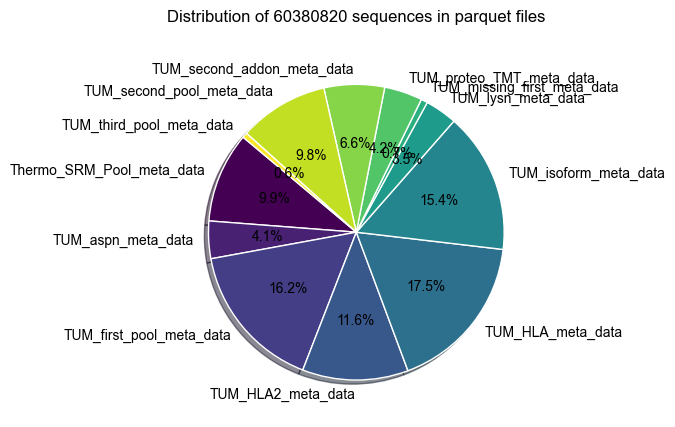

In [30]:
# create a pie diagram for the distribution of files in batches_parquet
import matplotlib.pyplot as plt

labels = [str(x).split("/")[-1].split(".")[0] for x in file_list]
# show sizes percentage to each bar
num_sizes = [batches_parquet[file].shape[0] for file in file_list]
total = sum([x for x in num_sizes])
sizes = [x/total*100 for x in num_sizes]

#title
plt.title(f'Distribution of {total} sequences in parquet files\n')

# font of percentages in white and parquet files in black

colors = plt.cm.viridis(np.linspace(0, 1, len(sizes)))

plt.xticks(rotation=90)
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)


C:\Users\micro\AppData\Local\Temp\ipykernel_24440\1027329076.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis')
C:\Users\micro\AppData\Local\Temp\ipykernel_24440\1027329076.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Percentages until exceeding 12%')


<BarContainer object of 12 artists>

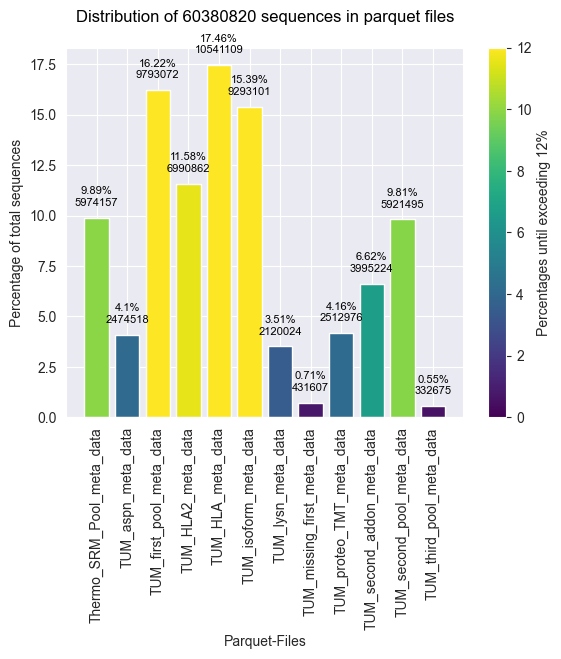

In [31]:
import matplotlib.pyplot as plt

labels = [str(x).split("/")[-1].split(".")[0] for x in file_list]
# show sizes percentage to each bar
num_sizes = [batches_parquet[file].shape[0] for file in file_list]
total = sum([x for x in num_sizes])
sizes = [x/total*100 for x in num_sizes]

# write percentage at top of bar
for index, value in enumerate(sizes):
    plt.text(index, value+0.5, str(round(value, 2))+"%\n"+str(num_sizes[index]) , ha='center', va='bottom', fontsize=8)
    
#title
plt.title(f'Distribution of {total} sequences in parquet files\n')
    
# legends
plt.xlabel('Parquet-Files')
plt.ylabel('Percentage of total sequences')


colormap = plt.cm.get_cmap('viridis')
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0, vmax=len(sizes)))
# add legends for color
# Create a colorbar legend
plt.colorbar(sm, label='Percentages until exceeding 12%')

plt.xticks(rotation=90)
plt.bar(labels, sizes,  color=colormap([x/len(sizes) for x in sizes]))


# Normalisieren:

In [32]:
def normalize_for_most_abundant(df_charge_list, df_intensity_list):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        charge_dict[i] = []
        charge_dict[i].append(df_intensity_list[index])

    # Normalize the precursor intensity based on the most abundant precursor intensity
    for key, value in charge_dict.items():
        if len(value) > 1:
         charge_dict[key] = sum(value) - min(value) / (max(value) - min(value))

    # convert list of one float to float values
    charge_dict = {key: value[0] for key, value in charge_dict.items()}

    return charge_dict

In [35]:
def get_most_abundant(df_charge_list, df_intensity_list, distributions=False):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        if i not in charge_dict:
            charge_dict[i] = df_intensity_list[index]
        else:
            charge_dict[i] += df_intensity_list[index]
    if distributions:
        #print(charge_dict)
        return charge_dict
    else:
        return max(charge_dict, key=charge_dict.get)


In [36]:
# load all parquets into df
df_dict = dict()
for file in file_list:
    df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_24440\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_24440\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_24440\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\A

# After aggregation (unique seq)

In [37]:
df_dict[file_list[0]].head(4)

,modified_sequence,precursor_charge,precursor_intensity
0,AAAASAAEAGIATTGTEGER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, ...","[165006700.0, 73345890.0, 16215490.0, 73345890..."
1,AAAC[UNIMOD:4]FFEQPPR,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1118398000.0, 894762400.0, 48477320.0, 707426..."
2,AAADFATHGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[950304000.0, 69180770.0, 52745530.0, 69180770..."
3,AAADLMAYC[UNIMOD:4]EAHAK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[11874490.0, 11874490.0, 10890660.0, 14086870...."


C:\Users\micro\AppData\Local\Temp\ipykernel_24440\931264446.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis')
C:\Users\micro\AppData\Local\Temp\ipykernel_24440\931264446.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Percentages until exceeding 12%')


<BarContainer object of 12 artists>

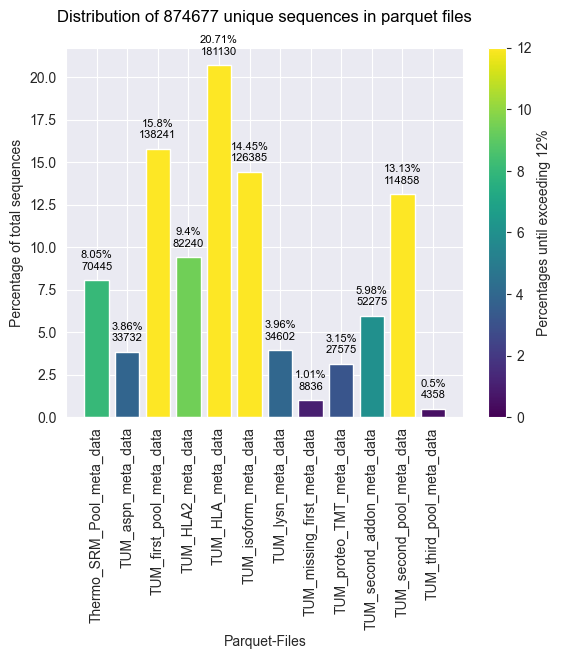

In [38]:
# create a pie diagram for the distribution of files in batches_parquet
import matplotlib.pyplot as plt

labels = [str(x).split("/")[-1].split(".")[0] for x in file_list]
# show sizes percentage to each bar
sizes_num = [df_dict[file].shape[0] for file in file_list]
total = sum([x for x in sizes_num])
sizes = [x/total*100 for x in sizes_num]

# write percentage at top of bar
for index, value in enumerate(sizes):
    plt.text(index, value+0.5, str(round(value, 2))+"%\n"+str(sizes_num[index]) , ha='center', va='bottom', fontsize=8)

#title 
plt.title(f'Distribution of {total} unique sequences in parquet files\n')
# legends
plt.xlabel('Parquet-Files')
plt.ylabel('Percentage of total sequences')





colormap = plt.cm.get_cmap('viridis')
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0, vmax=len(sizes)))
# add legends for color
# Create a colorbar legend
plt.colorbar(sm, label='Percentages until exceeding 12%')

plt.xticks(rotation=90)
plt.bar(labels, sizes,  color=colormap([x/len(sizes) for x in sizes]))


# init merged_df

In [39]:
# add filename to df
for file in file_list:
    df_dict[file]['parquet_file'] = file+str("+")
    
merged_df = pd.concat(list(df_dict.values())).groupby("modified_sequence")["precursor_charge", "precursor_intensity", "parquet_file"].sum().reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_24440\675895968.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_df = pd.concat(list(df_dict.values())).groupby("modified_sequence")["precursor_charge", "precursor_intensity", "parquet_file"].sum().reset_index()


In [40]:
# merged_df.head(4)
# for index, row in merged_df.iterrows():
#     if len(merged_df.at[index, 'parquet_file'].split("+d")) > 1:
#         print(merged_df.at[index, 'parquet_file'])

In [41]:
merged_df['seq_len_prepadding'] = merged_df['modified_sequence'].apply(lambda x: len(x))

In [42]:
len_counts = merged_df['seq_len_prepadding'].value_counts()
seq_too_long = len_counts[len_counts <= 10]
seq_too_long

87     9
82     8
85     7
89     6
90     5
107    4
97     4
95     4
92     4
83     3
86     3
98     3
91     2
84     2
93     2
88     2
96     2
110    2
105    1
104    1
102    1
94     1
103    1
115    1
99     1
125    1
108    1
Name: seq_len_prepadding, dtype: int64

In [43]:
seq_lengths = merged_df['seq_len_prepadding'].value_counts().index.values, merged_df['seq_len_prepadding'].value_counts().values
seq_too_long = pd.DataFrame()
seq_too_long['seq_len'] = seq_lengths[0][seq_lengths[0] >= 50]
seq_too_long['count'] = seq_lengths[1][seq_lengths[0] >= 50]
seq_too_long

,seq_len,count
0,50,1087
1,51,764
2,52,595
3,53,426
4,56,385
5,57,385
6,55,382
7,58,373
8,54,366
9,59,290


In [44]:
# give smallest seq_len when count <= 100
seq_len_cutoff_df = seq_too_long[seq_too_long['count'] <= 100]
seq_len_cutoff = min(seq_len_cutoff_df['seq_len'])

In [45]:
seq_len_cutoff

64

In [46]:
# reapply max len
max_len_seq = seq_len_cutoff-1

In [47]:
delete_a_row = True
if delete_a_row:
# delete row if seq_len_prepadding larger or equal to seq_len_cutoff
    index_to_delete_seq = merged_df[merged_df['seq_len_prepadding'] >= seq_len_cutoff].index
    deleted_rows = pd.DataFrame(merged_df, index=index_to_delete_seq)
    deleted_rows['reason'] = "seq_len_prepadding >= seq_len_cutoff"
    merged_df.drop(index_to_delete_seq, inplace=True)

In [48]:
deleted_rows.head(4)

,modified_sequence,precursor_charge,precursor_intensity,parquet_file,seq_len_prepadding,reason
67,AAAAAAGGGYTAM[UNIMOD:35]PAPM[UNIMOD:35]SVYSHPA...,"[4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, ...","[21548010.0, 11034140.0, 11034140.0, 4368891.0...",data/TUM_first_pool_meta_data.parquet+,68,seq_len_prepadding >= seq_len_cutoff
1296,AAAVVDGTPC[UNIMOD:4]RPDTVDIC[UNIMOD:4]VSGEC[UN...,"[5, 4, 4, 4, 4, 4, 4, 4, 4]","[7682801.0, 2344675.0, 2375326.0, 2344675.0, 2...",data/TUM_second_pool_meta_data.parquet+,70,seq_len_prepadding >= seq_len_cutoff
4981,AAPC[UNIMOD:4]PVPSSPGQELC[UNIMOD:4]GNNDVTYISSC...,"[3, 3]","[2010341.0, 2010341.0]",data/Thermo_SRM_Pool_meta_data.parquet+,70,seq_len_prepadding >= seq_len_cutoff
5259,AAPSC[UNIMOD:4]VDASIVEQKWWC[UNIMOD:4]HMQPC[UNI...,"[4, 4, 4, 4]","[11140010.0, 11140010.0, 11140010.0, 11140010.0]",data/TUM_second_pool_meta_data.parquet+,69,seq_len_prepadding >= seq_len_cutoff


In [49]:
# output all sequences with seq_len_prepadding >= 50
merged_df[merged_df['seq_len_prepadding'] >= seq_len_cutoff]

,modified_sequence,precursor_charge,precursor_intensity,parquet_file,seq_len_prepadding


In [50]:
merged_df['distributions'] = merged_df.apply(lambda x: normalize_for_most_abundant(x["precursor_charge"], x["precursor_intensity"]), axis=1)

In [51]:
# get percentages for each key in distributions according to values
merged_df['dist_percentages'] = merged_df.apply(lambda x: {key: value / sum(x["distributions"].values()) for key, value in x["distributions"].items()}, axis=1)

In [52]:
def multi_label_one_hot_precursor(charge_list, charges_included=charge_ranges):

    one_hot_encoded = [1 if label in charge_list else 0 for label in charges_included]

    return one_hot_encoded

In [53]:
merged_df['multi_label_vector'] = merged_df['precursor_charge'].apply(multi_label_one_hot_precursor)

In [54]:
merged_df.head(10)

,modified_sequence,precursor_charge,precursor_intensity,parquet_file,seq_len_prepadding,distributions,dist_percentages,multi_label_vector
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...",data/TUM_HLA2_meta_data.parquet+,22,"{2: 588796.3, 3: 4654280.0, 1: 791369.9}","{2: 0.09757254940809648, 3: 0.771285358381354,...","[1, 1, 1, 0, 0, 0]"
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",data/TUM_missing_first_meta_data.parquet+,21,{2: 303307.5},{2: 1.0},"[0, 1, 0, 0, 0, 0]"
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",data/TUM_first_pool_meta_data.parquet+,22,{2: 3067981.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]"
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300....",data/TUM_first_pool_meta_data.parquet+,26,"{2: 8093413.0, 3: 1414907.0}","{2: 0.8511927448802733, 3: 0.14880725511972673}","[0, 1, 1, 0, 0, 0]"
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",data/TUM_HLA2_meta_data.parquet+,15,{1: 1124818.0},{1: 1.0},"[1, 0, 0, 0, 0, 0]"
5,AAAAAAAAAAAAAAGAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[853119.3, 4332449.0, 3688977.0, 3469130.0, 33...",data/TUM_HLA2_meta_data.parquet+,17,{1: 679216.3},{1: 1.0},"[1, 0, 0, 0, 0, 0]"
6,AAAAAAAAAAAAAAGGLALGLH,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[33516080.0, 33516080.0, 8522070.0, 4549188.0,...",data/TUM_HLA2_meta_data.parquet+,22,{2: 365943.3},{2: 1.0},"[0, 1, 0, 0, 0, 0]"
7,AAAAAAAAAAAAAAVTSGV,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[4576179.0, 3336856.0, 4954145.0, 4317804.0, 3...",data/TUM_HLA2_meta_data.parquet+,19,"{2: 14611910.0, 1: 1211272.0}","{2: 0.923449531200488, 1: 0.07655046879951201}","[1, 1, 0, 0, 0, 0]"
8,AAAAAAAAAAAAAGAG,"[1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, ...","[1233316.0, 2671238.0, 11414430.0, 13683660.0,...",data/TUM_HLA2_meta_data.parquet+,16,"{1: 1879604.0, 2: 2586197.0}","{1: 0.4208884363633758, 2: 0.5791115636366242}","[1, 1, 0, 0, 0, 0]"
9,AAAAAAAAAAAAAK,"[1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, ...","[2540360.0, 31115000.0, 31115000.0, 70371250.0...",data/TUM_HLA2_meta_data.parquet+,14,"{1: 8372130.0, 2: 15308280.0}","{1: 0.3535466657883035, 2: 0.6464533342116965}","[1, 1, 0, 0, 0, 0]"


In [55]:
deleted_rows

,modified_sequence,precursor_charge,precursor_intensity,parquet_file,seq_len_prepadding,reason
67,AAAAAAGGGYTAM[UNIMOD:35]PAPM[UNIMOD:35]SVYSHPA...,"[4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, ...","[21548010.0, 11034140.0, 11034140.0, 4368891.0...",data/TUM_first_pool_meta_data.parquet+,68,seq_len_prepadding >= seq_len_cutoff
1296,AAAVVDGTPC[UNIMOD:4]RPDTVDIC[UNIMOD:4]VSGEC[UN...,"[5, 4, 4, 4, 4, 4, 4, 4, 4]","[7682801.0, 2344675.0, 2375326.0, 2344675.0, 2...",data/TUM_second_pool_meta_data.parquet+,70,seq_len_prepadding >= seq_len_cutoff
4981,AAPC[UNIMOD:4]PVPSSPGQELC[UNIMOD:4]GNNDVTYISSC...,"[3, 3]","[2010341.0, 2010341.0]",data/Thermo_SRM_Pool_meta_data.parquet+,70,seq_len_prepadding >= seq_len_cutoff
5259,AAPSC[UNIMOD:4]VDASIVEQKWWC[UNIMOD:4]HMQPC[UNI...,"[4, 4, 4, 4]","[11140010.0, 11140010.0, 11140010.0, 11140010.0]",data/TUM_second_pool_meta_data.parquet+,69,seq_len_prepadding >= seq_len_cutoff
7618,AC[UNIMOD:4]ANGGTC[UNIMOD:4]VEGGGAHRC[UNIMOD:4...,"[4, 4, 4, 4]","[23055950.0, 27295210.0, 27295210.0, 23055950.0]",data/TUM_second_pool_meta_data.parquet+,66,seq_len_prepadding >= seq_len_cutoff
...,...,...,...,...,...,...
826316,YSLC[UNIMOD:4]AKPC[UNIMOD:4]PDTC[UNIMOD:4]HSGF...,"[4, 4, 3, 4, 4, 3]","[26098360.0, 18106820.0, 5180162.0, 26098360.0...",data/TUM_second_pool_meta_data.parquet+,75,seq_len_prepadding >= seq_len_cutoff
827069,YSVC[UNIMOD:4]C[UNIMOD:4]KVC[UNIMOD:4]PNFC[UNI...,"[3, 3, 3, 3, 3, 3, 3]","[9691793.0, 9691793.0, 14857630.0, 14857630.0,...",data/TUM_second_pool_meta_data.parquet+,66,seq_len_prepadding >= seq_len_cutoff
827212,YSWQC[UNIMOD:4]VNQSVLC[UNIMOD:4]GPAENKC[UNIMOD...,"[3, 3]","[3064630.0, 3064630.0]",data/TUM_second_pool_meta_data.parquet+,65,seq_len_prepadding >= seq_len_cutoff
828732,YVAIC[UNIMOD:4]KPLHYM[UNIMOD:35]AIM[UNIMOD:35]...,[5],[7282049.0],data/TUM_second_pool_meta_data.parquet+,77,seq_len_prepadding >= seq_len_cutoff


# Dataset preprocessing

In [56]:
merged_df['multi_label_vector'].value_counts()

[0, 1, 0, 0, 0, 0]    326039
[0, 1, 1, 0, 0, 0]    221905
[0, 0, 1, 0, 0, 0]     96835
[0, 0, 1, 1, 0, 0]     51041
[1, 1, 0, 0, 0, 0]     47644
[1, 0, 0, 0, 0, 0]     25754
[0, 1, 1, 1, 0, 0]     21396
[0, 0, 0, 1, 0, 0]     20796
[0, 0, 0, 1, 1, 0]      5312
[0, 0, 1, 1, 1, 0]      5054
[0, 0, 0, 0, 1, 0]      2374
[0, 1, 0, 1, 0, 0]      1546
[0, 0, 0, 0, 0, 1]      1240
[1, 1, 1, 0, 0, 0]       960
[0, 1, 1, 1, 1, 0]       725
[0, 0, 0, 1, 1, 1]       557
[0, 0, 0, 0, 1, 1]       553
[0, 0, 1, 1, 1, 1]       330
[0, 0, 1, 0, 1, 0]       289
[0, 1, 1, 0, 1, 0]       111
[0, 1, 0, 1, 1, 0]        61
[0, 1, 0, 0, 1, 0]        57
[0, 0, 1, 1, 0, 1]        49
[0, 0, 0, 1, 0, 1]        40
[0, 0, 1, 0, 0, 1]        40
[1, 0, 1, 0, 0, 0]        36
[0, 1, 1, 1, 1, 1]        23
[0, 0, 1, 0, 1, 1]        22
[1, 1, 1, 1, 0, 0]         8
[0, 1, 1, 1, 0, 1]         6
[1, 1, 0, 1, 0, 0]         5
[0, 1, 1, 0, 0, 1]         5
[0, 1, 0, 0, 0, 1]         4
[0, 1, 0, 0, 1, 1]         3
Name: multi_la

In [57]:
value_counts = merged_df['multi_label_vector'].value_counts()
arrays_to_delete_series = value_counts[value_counts <= 20]

In [58]:
arrays_to_delete = arrays_to_delete_series.index.values
delete_a_row = True
if delete_a_row:
    for array in arrays_to_delete:
        index_to_delete = merged_df[merged_df['multi_label_vector'].apply(lambda x: np.array_equal(x, array))].index
        temp_df = pd.DataFrame(merged_df, index=index_to_delete)
        temp_df['reason'] = "multi_label_vector <= 20"
        deleted_rows = pd.concat([deleted_rows, temp_df], ignore_index=True)
        merged_df.drop(index_to_delete, inplace=True)

In [59]:
deleted_rows.head(4)

,modified_sequence,precursor_charge,precursor_intensity,parquet_file,seq_len_prepadding,reason,distributions,dist_percentages,multi_label_vector
0,AAAAAAGGGYTAM[UNIMOD:35]PAPM[UNIMOD:35]SVYSHPA...,"[4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, ...","[21548010.0, 11034140.0, 11034140.0, 4368891.0...",data/TUM_first_pool_meta_data.parquet+,68,seq_len_prepadding >= seq_len_cutoff,NaN,NaN,NaN
1,AAAVVDGTPC[UNIMOD:4]RPDTVDIC[UNIMOD:4]VSGEC[UN...,"[5, 4, 4, 4, 4, 4, 4, 4, 4]","[7682801.0, 2344675.0, 2375326.0, 2344675.0, 2...",data/TUM_second_pool_meta_data.parquet+,70,seq_len_prepadding >= seq_len_cutoff,NaN,NaN,NaN
2,AAPC[UNIMOD:4]PVPSSPGQELC[UNIMOD:4]GNNDVTYISSC...,"[3, 3]","[2010341.0, 2010341.0]",data/Thermo_SRM_Pool_meta_data.parquet+,70,seq_len_prepadding >= seq_len_cutoff,NaN,NaN,NaN
3,AAPSC[UNIMOD:4]VDASIVEQKWWC[UNIMOD:4]HMQPC[UNI...,"[4, 4, 4, 4]","[11140010.0, 11140010.0, 11140010.0, 11140010.0]",data/TUM_second_pool_meta_data.parquet+,69,seq_len_prepadding >= seq_len_cutoff,NaN,NaN,NaN


In [60]:
merged_df['multi_label_vector'].value_counts().index.values

array([list([0, 1, 0, 0, 0, 0]), list([0, 1, 1, 0, 0, 0]),
       list([0, 0, 1, 0, 0, 0]), list([0, 0, 1, 1, 0, 0]),
       list([1, 1, 0, 0, 0, 0]), list([1, 0, 0, 0, 0, 0]),
       list([0, 1, 1, 1, 0, 0]), list([0, 0, 0, 1, 0, 0]),
       list([0, 0, 0, 1, 1, 0]), list([0, 0, 1, 1, 1, 0]),
       list([0, 0, 0, 0, 1, 0]), list([0, 1, 0, 1, 0, 0]),
       list([0, 0, 0, 0, 0, 1]), list([1, 1, 1, 0, 0, 0]),
       list([0, 1, 1, 1, 1, 0]), list([0, 0, 0, 1, 1, 1]),
       list([0, 0, 0, 0, 1, 1]), list([0, 0, 1, 1, 1, 1]),
       list([0, 0, 1, 0, 1, 0]), list([0, 1, 1, 0, 1, 0]),
       list([0, 1, 0, 1, 1, 0]), list([0, 1, 0, 0, 1, 0]),
       list([0, 0, 1, 1, 0, 1]), list([0, 0, 0, 1, 0, 1]),
       list([0, 0, 1, 0, 0, 1]), list([1, 0, 1, 0, 0, 0]),
       list([0, 1, 1, 1, 1, 1]), list([0, 0, 1, 0, 1, 1])], dtype=object)

In [61]:
multi_label_classes_num = merged_df['multi_label_vector'].value_counts().index.values.shape[0]
multi_label_classes_num

28

In [62]:
len(merged_df['multi_label_vector'])

830789

In [63]:
merged_df["modified_sequence_vector"] = merged_df["modified_sequence"].apply(seq_translator)

In [64]:
# create a dictionary for every deleted_rows['parquet_file'].rstrip("+").split("+") and add the modified_sequence_vector to it
deleted_rows_dict = dict()
for index, row in deleted_rows.iterrows():
    for file in row['parquet_file'].rstrip("+").split("+"):
        if file not in deleted_rows_dict:
            deleted_rows_dict[file] = []
            deleted_rows_dict[file].append(row['modified_sequence'])
        else:
            deleted_rows_dict[file].append(row['modified_sequence'])

C:\Users\micro\AppData\Local\Temp\ipykernel_24440\2654565501.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis')
C:\Users\micro\AppData\Local\Temp\ipykernel_24440\2654565501.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Percentages until exceeding 12%')


<BarContainer object of 12 artists>

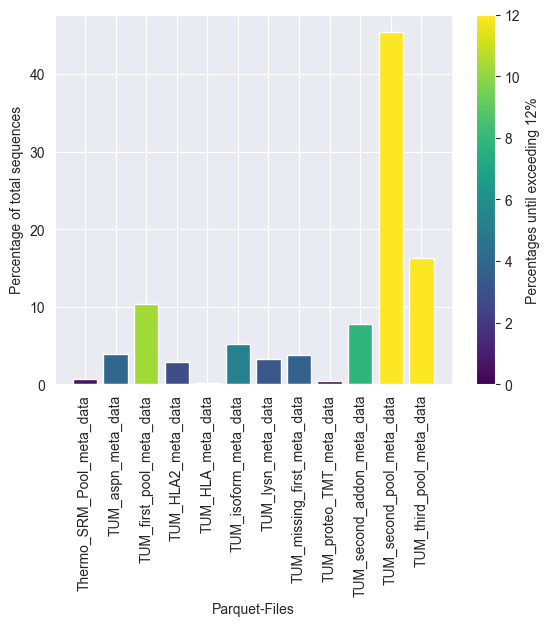

In [65]:
# create a pie diagram for the distribution of files in batches_parquet
import matplotlib.pyplot as plt

labels = [str(x).split("/")[-1].split(".")[0] for x in file_list]
# show sizes percentage to each bar
sizes = [len(deleted_rows_dict[file]) for file in file_list]
total = sum([x for x in sizes])
sizes = [x/total*100 for x in sizes]

# legends
plt.xlabel('Parquet-Files')
plt.ylabel('Percentage of total sequences')


colormap = plt.cm.get_cmap('viridis')
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0, vmax=len(sizes)))
# add legends for color
# Create a colorbar legend
plt.colorbar(sm, label='Percentages until exceeding 12%')

plt.xticks(rotation=90)
plt.bar(labels, sizes,  color=colormap([x/len(sizes) for x in sizes]))


C:\Users\micro\AppData\Local\Temp\ipykernel_24440\1686536364.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis')
C:\Users\micro\AppData\Local\Temp\ipykernel_24440\1686536364.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Percentages until exceeding 12%')


0.10688634538974395 888 830789


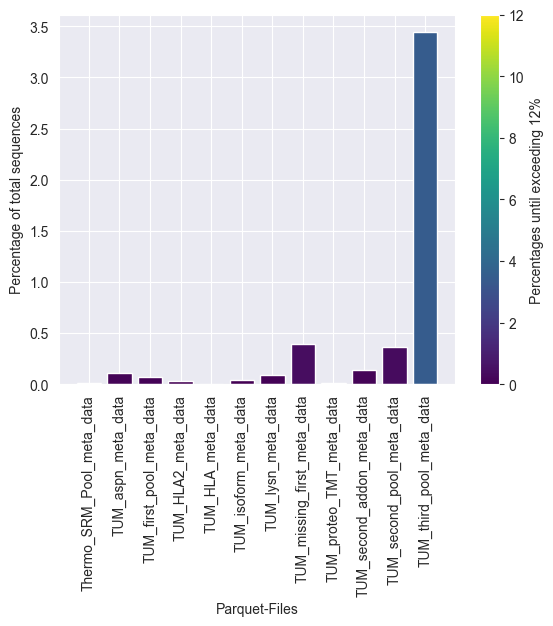

In [66]:
# in comprarison to the original distribution

# create a pie diagram for the distribution of files in batches_parquet
import matplotlib.pyplot as plt

labels = [str(x).split("/")[-1].split(".")[0] for x in file_list]
# show sizes percentage to each bar
sizes = [len(deleted_rows_dict[file]) for file in file_list]
total = sum([x for x in sizes])
abs_sizes = [len(df_dict[file]) for file in file_list]
# set sizes to abs_total of same index / x

sizes = [x/abs_sizes[index]*100 for index, x in enumerate(sizes)]

# legends
plt.xlabel('Parquet-Files')
plt.ylabel('Percentage of total sequences')


colormap = plt.cm.get_cmap('viridis')
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0, vmax=len(sizes)))
# add legends for color
# Create a colorbar legend
plt.colorbar(sm, label='Percentages until exceeding 12%')

plt.xticks(rotation=90)
plt.bar(labels, sizes,  color=colormap([x/len(sizes) for x in sizes]))

print(deleted_rows.shape[0]/merged_df.shape[0]*100, deleted_rows.shape[0], merged_df.shape[0])


In [67]:
merged_df.head(4)

,modified_sequence,precursor_charge,precursor_intensity,parquet_file,seq_len_prepadding,distributions,dist_percentages,multi_label_vector,modified_sequence_vector
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...",data/TUM_HLA2_meta_data.parquet+,22,"{2: 588796.3, 3: 4654280.0, 1: 791369.9}","{2: 0.09757254940809648, 3: 0.771285358381354,...","[1, 1, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",data/TUM_missing_first_meta_data.parquet+,21,{2: 303307.5},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",data/TUM_first_pool_meta_data.parquet+,22,{2: 3067981.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300....",data/TUM_first_pool_meta_data.parquet+,26,"{2: 8093413.0, 3: 1414907.0}","{2: 0.8511927448802733, 3: 0.14880725511972673}","[0, 1, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [68]:
# create a dictionary for every deleted_rows['parquet_file'].rstrip("+").split("+") and add the modified_sequence_vector to it
merged_rows_dict = dict()
for index, row in merged_df.iterrows():
    for file in row['parquet_file'].rstrip("+").split("+"):
        if file not in merged_rows_dict:
            merged_rows_dict[file] = []
            merged_rows_dict[file].append(row['modified_sequence'])
        else:
            merged_rows_dict[file].append(row['modified_sequence'])

C:\Users\micro\AppData\Local\Temp\ipykernel_24440\3299214290.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis')
C:\Users\micro\AppData\Local\Temp\ipykernel_24440\3299214290.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Percentages until exceeding 12%')


<BarContainer object of 12 artists>

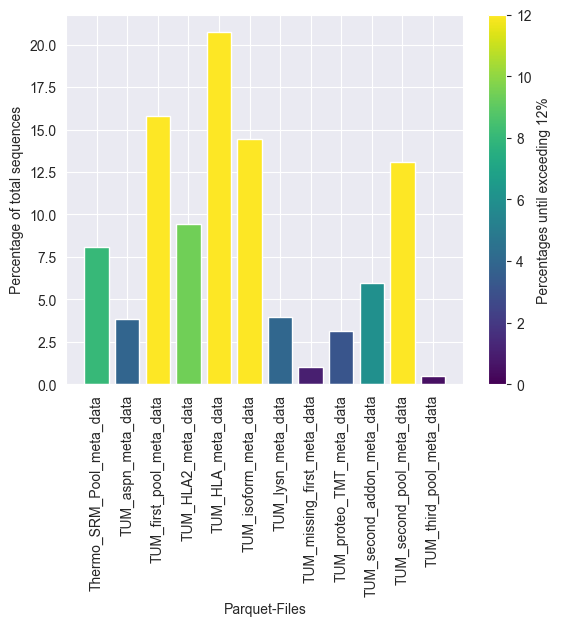

In [69]:
# create a pie diagram for the distribution of files in batches_parquet
import matplotlib.pyplot as plt

labels = [str(x).split("/")[-1].split(".")[0] for x in file_list]
# show sizes percentage to each bar
sizes = [len(merged_rows_dict[file]) for file in file_list]
total = sum([x for x in sizes])
sizes = [x/total*100 for x in sizes]

# legends
plt.xlabel('Parquet-Files')
plt.ylabel('Percentage of total sequences')


colormap = plt.cm.get_cmap('viridis')
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0, vmax=len(sizes)))
# add legends for color
# Create a colorbar legend
plt.colorbar(sm, label='Percentages until exceeding 12%')

plt.xticks(rotation=90)
plt.bar(labels, sizes,  color=colormap([x/len(sizes) for x in sizes]))


# Charge distributions


In [70]:
test_df = deleted_rows['precursor_charge'].value_counts()

In [71]:
test_df

[3, 3]                                                                                                                                                                                                                                                                                     65
[3]                                                                                                                                                                                                                                                                                        42
[3, 3, 3, 3]                                                                                                                                                                                                                                                                               35
[4]                                                                                                                                           

In [72]:
'''
Generate overview plot for precursor_charge distribution in combined dataset
'''
def precursor_charge_distribution_plot(df):
    # plot the distirbution of precursor_charge for the whole dataset
    sns.set_theme(style="darkgrid")
    sns.set_context("paper")
    ax = sns.countplot(x='precursor_charge', data=df, palette="viridis")
    plt.xlabel('Precursor Charge')
    plt.ylabel('Count')
    plt.title('Distribution of Precursor Charge')
    # add percentage of each charge state to the plot
    total = df["precursor_charge"].value_counts()
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height() + 5
        ax.annotate(percentage, (x, y))
    plt.show()

In [74]:
precursor_charge_distribution_plot(deleted_rows)

TypeError: unhashable type: 'list'

### Model

# Embedding model test:

In [78]:
# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [79]:
df1 = merged_df.sample(frac = 0.1, random_state = 42)
test_ds_embed = np.array(df1['modified_sequence_vector'])
test_ds_embed_raw = np.array(df1['modified_sequence'])
test_labels_embed = np.array(df1['multi_label_vector'])

df2 = merged_df.drop(df1.index)
trainval_ds_embed = np.array(df2['modified_sequence_vector'])
trainval_ds_embed_raw = np.array(df2['modified_sequence'])
trainval_labels_embed = np.array(df2['multi_label_vector'])

In [80]:
# Perform the split train and val
train_indicies_embed, val_indicies_embed = next(sss.split(trainval_ds_embed, trainval_labels_embed, trainval_ds_embed_raw))

In [81]:
train_ds_embed, train_labels_embed = trainval_ds_embed[train_indicies_embed], trainval_labels_embed[train_indicies_embed]
val_ds_embed, val_labels_embed = trainval_ds_embed[val_indicies_embed], trainval_labels_embed[val_indicies_embed]
train_ds_embed_raw, val_ds_embed_raw = trainval_ds_embed_raw[train_indicies_embed], trainval_ds_embed_raw[val_indicies_embed]

charges = [1,2,3,4,5,6] # TODO SELECT CLASSES
num_classes = len(charges)

In [82]:
train_ds_embed  = [np.array(x) for x in train_ds_embed]
val_ds_embed = [np.array(x) for x in val_ds_embed]
test_ds_embed = [np.array(x) for x in test_ds_embed]

In [83]:
train_labels_embed = [np.array(x) for x in train_labels_embed]
val_labels_embed = [np.array(x) for x in val_labels_embed]
test_labels_embed = [np.array(x) for x in test_labels_embed]

In [84]:
train_ds_embed = tf.convert_to_tensor(train_ds_embed)
val_ds_embed = tf.convert_to_tensor(val_ds_embed)
train_labels_embed = tf.convert_to_tensor(train_labels_embed)
val_labels_embed = tf.convert_to_tensor(val_labels_embed)

test_ds_embed = tf.convert_to_tensor(test_ds_embed)
test_labels_embed = tf.convert_to_tensor(test_labels_embed)

In [85]:
train_ds_embed[3]

<tf.Tensor: shape=(125,), dtype=int32, numpy=
array([ 1, 20, 18, 15,  1,  4, 10, 16, 10,  9,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])>

In [86]:
train_labels_embed[3]

<tf.Tensor: shape=(6,), dtype=int32, numpy=array([0, 1, 1, 0, 0, 0])>

In [87]:
len(train_ds_embed), len(val_ds_embed), len(test_ds_embed)

(598168, 149542, 83079)

# Init Model

In [88]:
# MODEL
seq_len_after_cutoff = seq_len_cutoff-1

from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA_embed = Input(shape=train_ds_embed[0].shape)
x = Model(inputs=inputA_embed, outputs=inputA_embed)
y = Embedding(input_dim=voc_len, output_dim=max_len_seq, input_length=max_len_seq)(inputA_embed)
y = Flatten()(y)
y = Dense(seq_len_after_cutoff, activation="relu")(y)
z = Dense(num_classes, activation="sigmoid")(y)
model_embed = Model(inputs=[x.input], outputs=z)

In [89]:
model_embed.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 125)]             0         
                                                                 
 embedding (Embedding)       (None, 125, 63)           1449      
                                                                 
 flatten (Flatten)           (None, 7875)              0         
                                                                 
 dense (Dense)               (None, 63)                496188    
                                                                 
 dense_1 (Dense)             (None, 6)                 384       
                                                                 
Total params: 498,021
Trainable params: 498,021
Non-trainable params: 0
_________________________________________________________________


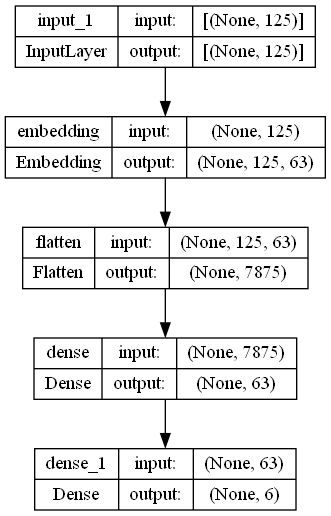

In [90]:
# plot model
tf.keras.utils.plot_model(model_embed, show_shapes=True, show_layer_names=True)

In [91]:
# Compile the model
model_embed.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['binary_accuracy'])

In [92]:
checkpoint_callback_embed = ModelCheckpoint('precursor_charge_prediction_model_embed/embed_multi_label.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping_embed = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [94]:
# Train the model
# X_train, X_test, y_train, y_test
history_embed = model_embed.fit(train_ds_embed, train_labels_embed, epochs=150, batch_size=4096, validation_data=(val_ds_embed, val_labels_embed), callbacks=[]) #WandbCallback()

Epoch 1/150
147/147 [==============================] - 18s 108ms/step - loss: 0.3979 - binary_accuracy: 0.8433 - val_loss: 0.3158 - val_binary_accuracy: 0.8641
Epoch 2/150
147/147 [==============================] - 16s 107ms/step - loss: 0.2997 - binary_accuracy: 0.8732 - val_loss: 0.2866 - val_binary_accuracy: 0.8777
Epoch 3/150
147/147 [==============================] - 15s 103ms/step - loss: 0.2768 - binary_accuracy: 0.8817 - val_loss: 0.2655 - val_binary_accuracy: 0.8878
Epoch 4/150
147/147 [==============================] - 16s 106ms/step - loss: 0.2538 - binary_accuracy: 0.8952 - val_loss: 0.2417 - val_binary_accuracy: 0.9033
Epoch 5/150
147/147 [==============================] - 16s 109ms/step - loss: 0.2315 - binary_accuracy: 0.9097 - val_loss: 0.2224 - val_binary_accuracy: 0.9148
Epoch 6/150
147/147 [==============================] - 15s 103ms/step - loss: 0.2154 - binary_accuracy: 0.9194 - val_loss: 0.2095 - val_binary_accuracy: 0.9239
Epoch 7/150
147/147 [===================

In [95]:
import datetime
date = datetime.datetime.now().strftime("%m%d%Y")
print(date)

09142023


In [96]:
model_embed.save(f'precursor_charge_prediction_model_embed/history_embed_150epoch_{date}.h5')

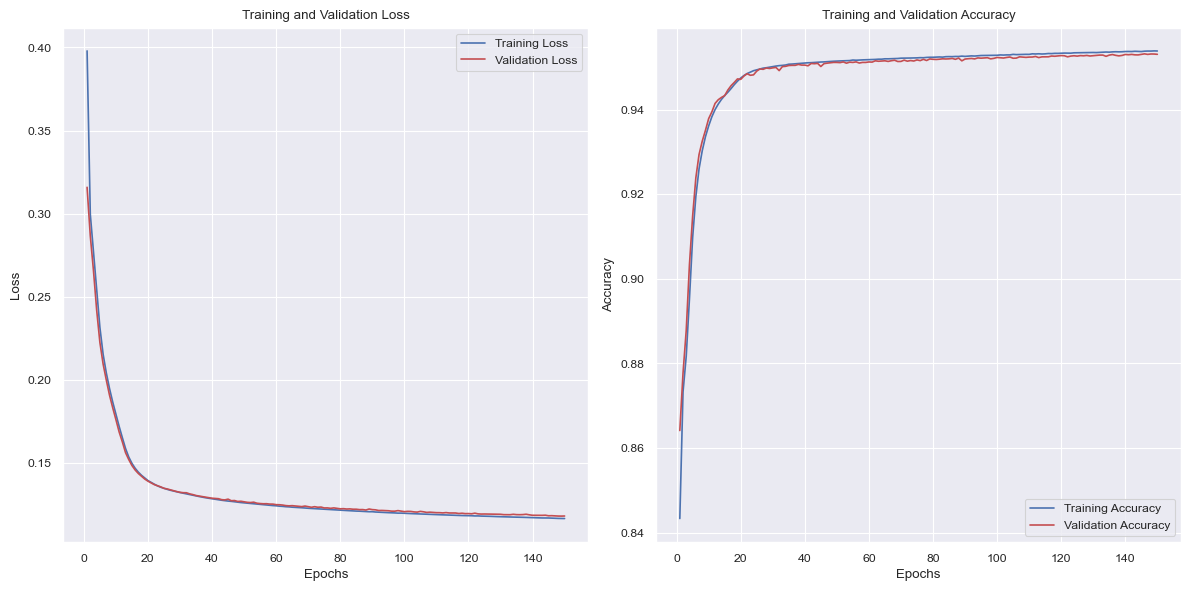

In [97]:
# Access the loss, validation loss, and accuracy from the history object
loss = history_embed.history['loss']
val_loss = history_embed.history['val_loss']
#accuracy = history_embed.history['categorical_accuracy']
accuracy = history_embed.history['binary_accuracy']
val_accuracy = history_embed.history['val_binary_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

C:\Users\micro\AppData\Local\Temp\ipykernel_24440\3079441391.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax1.plot(epochs, loss, 'b', label='Training Loss', color=b)
C:\Users\micro\AppData\Local\Temp\ipykernel_24440\3079441391.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  ax1.plot(epochs, val_loss, 'r', label='Validation Loss', color=r)
C:\Users\micro\AppData\Local\Temp\ipykernel_24440\3079441391.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax2.plot(epochs,

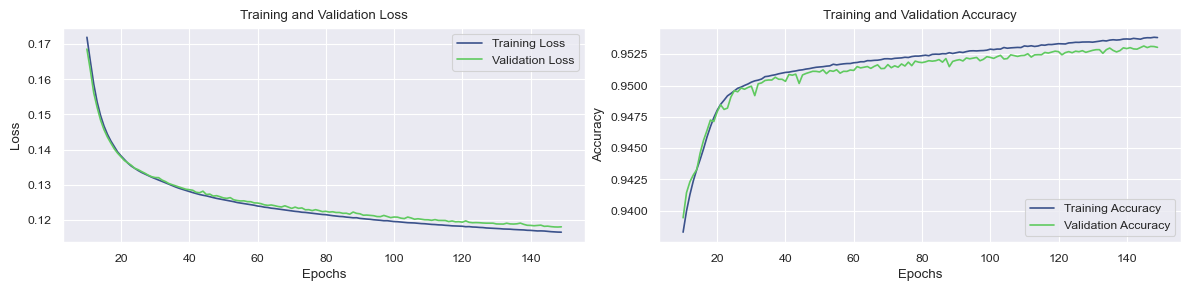

In [109]:
# Access the loss, validation loss, and accuracy from the history object
loss = history_embed.history['loss']
val_loss = history_embed.history['val_loss']
#accuracy = history_embed.history['categorical_accuracy']
accuracy = history_embed.history['binary_accuracy']
val_accuracy = history_embed.history['val_binary_accuracy']


# only plot epoch 10 to 150
loss = loss[10:]
val_loss = val_loss[10:]
accuracy = accuracy[10:]
val_accuracy = val_accuracy[10:]
# start numbering at 10
epochs = range(10, len(loss) + 10)

# get 2 colors from viridis at 25% and 75%
colors = plt.cm.viridis(np.linspace(0,1,100))
b = colors[25]
r = colors[75]


# Plot the loss, validation loss, and accuracy curves
#epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss', color=b)
ax1.plot(epochs, val_loss, 'r', label='Validation Loss', color=r)
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy', color=b)
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy', color=r)
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Inference

In [98]:
def decode_one_hot(one_hot, charges = [1,2,3,4,5,6]):
    for index, hot in enumerate(one_hot):
        if hot == 1:
            return charges[index]

In [99]:
def predictions_no_hot(one_hot, charges = [1,2,3,4,5,6]):
    index = np.argmax(one_hot)
    return(charges[index])

In [100]:
np.argmax([0, 0 ,0 ,0, 1])

4

In [254]:
test_df = pd.DataFrame(columns=['modified_sequence_vector', 'true_label', 'pred_label', 'prediction'])
# every row of tensor to list
test_df['modified_sequence_vector'] = test_ds_embed.numpy().tolist()
test_df['true_label'] = test_labels_embed.numpy().tolist()
test_df['pred_label'] = None
# remove all "0" from modified_sequence_vector
seq_len = []

In [255]:
def generate_charge_prediction_text(charge_predictions, input_sequence=input_sequence):
    max_charge_index = np.argmax(charge_predictions)
    max_charge_value = round(charge_predictions[max_charge_index], 2)

    charge_text = f"The predicted charge state for the input sequence '{input_sequence}' is {max_charge_index+1} [{round(max_charge_value*100,2)}%]."
    percentage_text = "Prediction percentages for all states:\n"

    for index, prediction in enumerate(charge_predictions):
        if index != max_charge_index:
            percentage = round(prediction * 100, 2)
            percentage_text += f"Charge state {index+1}: {percentage}%\n"
        else:
            percentage = round(prediction * 100, 2)
            percentage_text += f"--Charge state {index+1}: {percentage}%\n"

    full_text = charge_text + "\n" + percentage_text
    return full_text

In [256]:
def normalize_probabilities(probabilities):
    total = sum(probabilities)
    normalized_probabilities = [p / total for p in probabilities]
    return normalized_probabilities

In [104]:
# # TODO prediction
# #input_sequence = "NGVVIATENKHKSPLYEQHSVH"
# input_sequence = "EM[UNIMOD:35]LTRAIKTQLVLLT"
# #input_sequence = "AAAGCNN"
# input_sequence_vector = seq_translator(input_sequence, max_len=63)
# input_sequence_vector = np.expand_dims(tf.convert_to_tensor(np.array(input_sequence_vector)), axis=0)
# print(input_sequence_vector)
# test_give = model_embed.predict(input_sequence_vector, verbose=False)[0]
# #test_give = normalize_probabilities(test_give) # TODO manually switch off
# print([round(x, 2) for x in test_give], sum([round(x, 2) for x in test_give]))
# counter = 1
# print("-----------------------------")
# print("Sequence: ", input_sequence)
# for x in test_give:
#     print(f"charge state {counter}: ", round(x, 2))
#     counter += 1
# print("-----------------------------")
# test_give = normalize_probabilities(test_give) # TODO manually switch off
# print(generate_charge_prediction_text(test_give))
# 
# # TODO decisionmaking for which state, state distribution cutoffs ?

[[ 4 22 10 17 15  1  8  9 17 14 10 18 10 10 17  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


ValueError: in user code:

    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 125), found shape=(None, 63)


In [ ]:
for index, row in test_df.iterrows():
    solut = np.expand_dims(tf.convert_to_tensor(np.array(test_df.at[index, "modified_sequence_vector"])), axis=0)
    test_df.at[index, 'prediction'] = model_embed.predict(solut, verbose=False)

In [ ]:
test_df.head(4)

In [ ]:
def predictions_multi_hot(pred_hot, charges = [1,2,3,4,5,6]):
    pred_hot = pred_hot[0]
    multi_hot_list = []
    prime = np.max(pred_hot)
    base = np.min(pred_hot)
    for index, hot in enumerate(pred_hot):
        #print(hot)
        if hot == prime:
            multi_hot_list.append(1)
        elif hot == base:
            multi_hot_list.append(0)
        elif 0.5 <= hot < prime:
            multi_hot_list.append(1)
        else:
            multi_hot_list.append(0)
    return multi_hot_list

predictions_multi_hot([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6]])

In [ ]:
test_df['pred_label'] = test_df['prediction'].apply(predictions_multi_hot)

In [ ]:
test_df.head(4)

In [ ]:
test_df['multi_acc'] = [None for x in range(len(test_df))]
for index, row in test_df.iterrows():
    multi_acc_list = []
    for index2, hot in enumerate(test_df.at[index, 'pred_label']):
        if hot == test_df.at[index, 'true_label'][index2]:
            multi_acc_list.append(1)
        else:
            multi_acc_list.append(0)
    test_df.at[index, 'multi_acc'] = multi_acc_list

In [ ]:
test_df.head(4)

In [ ]:
test_df['accuracy'] = [None for x in range(len(test_df))]
for index, row in test_df.iterrows():
    accuracy = 0
    for index2, hot in enumerate(test_df.at[index, 'multi_acc']):
        if hot == 1:
            accuracy+=(1/len(test_df.at[index, 'multi_acc']))
        else:
            accuracy+=0
    test_df.at[index, 'accuracy'] = accuracy

In [ ]:
test_df.head(4)

In [ ]:
test_df['accuracy'].mean()

In [ ]:
first_index = 0
last_index = 0
for index2, hot in enumerate([0,0,0,0,0,0,1,0,0,0,0,0,0,0,1]):
    index2 = index2+1
    if hot == 1:
        if first_index == 0:
            first_index = index2
            last_index = index2
        else:
            last_index = index2

print(first_index, last_index)

In [ ]:
# spectrum
test_df['spec_acc'] = [None for x in range(len(test_df))]
for index, row in test_df.iterrows():
    first_index = 0
    last_index = 0
    for index2, hot in enumerate(test_df.at[index, 'true_label']):
        index2 = index2+1
        if hot == 1:
            if first_index == 0:
                first_index = index2
                last_index = index2
            else:
                last_index = index2
    range_1 = last_index-first_index+1
    
    first_index2 = 0
    last_index2 = 0
    for index3, hot2 in enumerate(test_df.at[index, 'pred_label']):
        index3 = index3+1
        if hot2 == 1:
            if first_index2 == 0:
                first_index2 = index3
                last_index2 = index3
            else:
                last_index2 = index3
    range_2 = last_index2-first_index2+1
    
    test_df.at[index, 'range_1'] = range_1
    test_df.at[index, 'range_2'] = range_2

    # if test_df.at[index, 'accuracy'] == 1:
    #     test_df.at[index, 'spec_acc'] = 1
    # else:
    #     diff = range_1-range_2
    #     if diff < 0:
    #         diff = diff * -1
    #     test_df.at[index, 'spec_acc'] = 1-(diff/range_1)
    
    if range_1 == range_2 and test_df.at[index, 'true_label'] == test_df.at[index, 'pred_label']:
        test_df.at[index, 'spec_acc'] = 1
    else:
        test_df.at[index, 'spec_acc'] = 0

In [ ]:
test_df['spec_acc'].mean()

In [ ]:
test_df.head(11)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sn

new_df = pd.DataFrame(columns=['charge'])

charge_dict_true = dict()
charge_dict_pred = dict()
for index, row in test_df.iterrows():
    for index2 in range(len(test_df.at[index, 'true_label'])):
        if index2+1 not in charge_dict_true:
            charge_dict_true[index2+1] = []
            charge_dict_pred[index2+1] = []
            charge_dict_true[index2+1].append(test_df.at[index, 'true_label'][index2])
            charge_dict_pred[index2+1].append(test_df.at[index, 'pred_label'][index2])
        else:
            charge_dict_true[index2+1].append(test_df.at[index, 'true_label'][index2])
            charge_dict_pred[index2+1].append(test_df.at[index, 'pred_label'][index2])

new_df['charge'] = [0, 1]  
for key, value in charge_dict_true.items():
    matrix = confusion_matrix(value, charge_dict_pred[key])
    new_df[f'{key}_accuracy'] = matrix.diagonal()/matrix.sum(axis=1)
    new_df[f'{key}_precision'] = precision_score(value, charge_dict_pred[key], average=None)
    new_df[f'{key}_recall'] = recall_score(value, charge_dict_pred[key], average=None)
    new_df[f'{key}_f1'] = f1_score(value, charge_dict_pred[key], average=None)


In [ ]:
new_df

In [ ]:
new_df2 = pd.DataFrame(columns=['charge','accuracy','precision','recall','f1'])

charges_list = []
to_take_list = []
for meh in range(1,7):
    for value in ["not-",""]:
        ah = value+str(meh)
        charges_list.append(ah)
        to_take_list.append(f'{meh}')
new_df2['charge'] = charges_list

counter = 0
for index, row in new_df2.iterrows():
        if counter > 1:
            counter = 0
        new_df2.at[index, 'accuracy'] = new_df.at[counter, f'{to_take_list[index]}_accuracy']
        new_df2.at[index, 'precision'] = new_df.at[counter, f'{to_take_list[index]}_precision']
        new_df2.at[index, 'recall'] = new_df.at[counter, f'{to_take_list[index]}_recall']
        new_df2.at[index, 'f1'] = new_df.at[counter, f'{to_take_list[index]}_f1']
        counter += 1
        
        



In [ ]:
new_df2

In [ ]:
for row in test_df['modified_sequence_vector']:
    seq = [x for x in row if x != 0]
    seq_len.append(len(seq))
test_df['seq_length'] = seq_len

In [ ]:
# calculate error for each class corresponding to sequence length, TODO normalize for sequence length occurence
seq_len_dict = dict()
seq_len_correct = dict()
for index, length in test_df['seq_length'].items():
    if length in seq_len_dict:
        seq_len_dict[length] += 1
        if test_df.at[index, 'true_label'] == predict_df.at[index, 'pred_label']:
            seq_len_correct[length] += 1
    else:
        seq_len_dict[length] = 1
        if test_df.at[index, 'true_label'] == test_df.at[index, 'pred_label']:
            seq_len_correct[length] = 1
        else:
            seq_len_correct[length] = 0

print(len(seq_len_dict), sum(seq_len_dict.values()))
print(seq_len_dict[11])
print(seq_len_correct[11])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sn


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sn

new_df = pd.DataFrame(columns=['charge','accuracy'])

charge_dict_true = dict()
charge_dict_pred = dict()
for index, row in test_df.iterrows():
    for index2 in range(len(test_df.at[index, 'true_label'])):
        if index2+1 not in charge_dict_true:
            charge_dict_true[index2+1] = []
            charge_dict_pred[index2+1] = []
            charge_dict_true[index2+1].append(test_df.at[index, 'true_label'][index2])
            charge_dict_pred[index2+1].append(test_df.at[index, 'pred_label'][index2])
        else:
            charge_dict_true[index2+1].append(test_df.at[index, 'true_label'][index2])
            charge_dict_pred[index2+1].append(test_df.at[index, 'pred_label'][index2])

for key, value in charge_dict_true.items():

    true_labels = value
    predicted_labels = charge_dict_pred[key]
    
    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)

    classes_here = [0,key]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_here)
    
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    # add legend title and axis labels
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix, Charge State {key}')
    # plt.colorbar(label="Number of Samples")
    # write text below plot
    plt.text(-0.5, 2.1, f"Accuracy: {round(accuracy_score(true_labels, predicted_labels), 3)}\nPrecision (weighted): {round(precision_score(true_labels, predicted_labels, average='weighted'), 3)}\nRecall (weighted): {round(recall_score(true_labels, predicted_labels, average='weighted'), 3)}\nF1-score (weighted): {round(f1_score(true_labels, predicted_labels, average='weighted'), 3)}", fontsize=10)
    
    # write text for topk below plot
    #plt.text(3.5, 7.5, f"TopK-Accuracy: {round(topK_accuracy, 3)}\n\n\n", fontsize=10)
    
    plt.show()


#sn.heatmap(cm2, annot=True, cmap="crest")
# TODO  check if most abundant is chosen

In [ ]:
# iterate all rows of grouped_df_embed
size_of_df = grouped_df_embed.shape[0]
true_counter = 0
for index, row in grouped_df_embed.iterrows():
    if row['true_label'] == row['pred_label']:
        true_counter += 1

print(true_counter/size_of_df, true_counter, size_of_df)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sn

true_labels = grouped_df_embed['true_label']
predicted_labels = grouped_df_embed['pred_label']

cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
print("Accuracy: ", accuracy_score(true_labels, predicted_labels))
print("Precision: ", precision_score(true_labels, predicted_labels, average='weighted'))
print("Recall: ", recall_score(true_labels, predicted_labels, average='weighted'))
print("F1: ", f1_score(true_labels, predicted_labels, average='weighted'))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

#sn.heatmap(cm2, annot=True, cmap="crest")
# TODO  check if most abundant is chosen

In [ ]:
from sklearn.metrics import confusion_matrix

new_df = pd.DataFrame(columns=['charge','accuracy'])

matrix = confusion_matrix(true_labels, predicted_labels)
new_df['charge'] = [1,2,3,4,5,6]
new_df['accuracy'] = matrix.diagonal()/matrix.sum(axis=1)
new_df['precision'] = precision_score(true_labels, predicted_labels, average=None)
new_df['recall'] = recall_score(true_labels, predicted_labels, average=None)
new_df['f1'] = f1_score(true_labels, predicted_labels, average=None)


In [ ]:
new_df

In [ ]:
grouped_df_embed.head(4)

# IGNORE FROM HERE

## Check in with Franzi's group for reporting

### Multilable Model
#### WIP in precursor_charge_predictor

## Model Testing
### check if models only predict charge 2 or also other charges. Due to 'overrepresentation' the best bet for the model could be to only output charge state 2

## Hyperparameter Tuning

# Inference

In [ ]:
batches_parquet[file_list[1]]["precursor_charge"].value_counts()

In [ ]:
last_model = keras.models.load_model('precursor_charge_prediction_model_cce_alpha/cce_wo7_allSequences.h5')

In [ ]:
batches_parquet.keys()

In [ ]:
# Make validation data
inference_df = batches_parquet[file_list[1]][["precursor_charge", "modified_sequence_vector", "precursor_intensity"]].copy()

In [ ]:
inference_df.head(4)

In [ ]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

In [ ]:
inference_df = inference_df[inference_df['modified_sequence_vector'].apply(lambda x: len(x) <= 50)]

In [ ]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

In [ ]:
[i for i in inference_df["precursor_charge"] if i not in [2,3,4]]

In [ ]:
[i for i in inference_df["precursor_intensity"] if i > 1000000000000]

In [ ]:
inference_df

In [ ]:
inference_df[list(range(0, 50))] = pd.DataFrame(inference_df["modified_sequence_vector"].tolist(), index= inference_df.index)

In [ ]:
inference_df.drop("modified_sequence_vector", axis=1, inplace=True)

In [ ]:
inference_df.head(4)

In [ ]:
inference_ds = tf.convert_to_tensor(inference_df)

In [ ]:
inference_target = inference_ds[:, 0]
inference_features = inference_ds[:, 1:]

In [ ]:
inference_target_labels =  np.array([one_hot_precursor(i, charges=charge_ranges) for i in inference_target])

In [ ]:
results = model_cce.evaluate(inference_features, inference_target_labels, batch_size=256)
print("test loss, test acc:", results)

## Evaluate the models
- confusion matrix
- accuracy
- loss

Confusion Matrix

In [ ]:
import sklearn
matrix = sklearn.metrics.confusion_matrix(train_ds_labels.argmax(axis=1), inference_target_labels.argmax(axis=1))

In [ ]:
#!pip install scikit-learn
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install matplotlib --upgrade
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
#do_predictions = model.predict(test_ds)

y_pred = []
y_true = []

# iterate over the dataset
for index, i in enumerate(inference_ds):   # use dataset.unbatch() with repeat
   print(inference_target_labels[index])
   print(inference_features[index])
   # append true labels
   y_true.append(inference_target_labels[index])
   # compute predictions
   preds = model_cce.predict(inference_features[index])
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))
# convert the true and predicted labels into tensors
true_labels = tf.cast(tf.concat([item for item in y_true], axis = 0), tf.float32)
predicted_labels = tf.cast(tf.concat([item for item in y_pred], axis = 0), tf.float32)


cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
report = classification_report(true_labels,predicted_labels, target_names=class_names)

report_dict = classification_report(true_labels, predicted_labels, output_dict=True)
#print(report_dict)
print(report)

#pd.DataFrame(report_dict).transpose()


Accuracy/ Sens/ Spec

In [ ]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    #print(y_pred.shape, y_true.shape)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(K.cast(y_pos * y_pred_pos, 'float32'))
    tn = K.sum(K.cast(y_neg * y_pred_neg, 'float32'))
    fp = K.sum(K.cast(y_neg * y_pred_pos, 'float32'))
    fn = K.sum(K.cast(y_pos * y_pred_neg, 'float32'))

    print("OVERALL:")
    print(" Accuracy ", ((tp + tn) / (tp + tn + fp + fn)).numpy())
    print(" Sensitivity ", (tp / (tp + fn)).numpy())
    print(" Specificity ", (tn / (tn + fp)).numpy())

    numerator = (tp * tn - fp * fn)
    #print(tp.numpy(), fp.numpy())
    test = (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    #print(test)
    denominator = K.sqrt(K.cast(test, 'float32'))

    return numerator / (denominator + K.epsilon())


#print(true_labels, predicted_labels)
print(" matthews_correlation(rounded): ", (matthews_correlation(true_labels, predicted_labels).numpy()))

MCC

In [ ]:
from sklearn.metrics import matthews_corrcoef

print("matthews_correlation:", matthews_corrcoef(true_labels, predicted_labels))

Direct eval:

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

eval_prec = Precision()
eval_rec = Recall()
eval_acc = BinaryAccuracy()

In [ ]:
for batch in test_ds.as_numpy_iterator():
    X, y = batch
    y = tf.keras.utils.to_categorical(y, num_classes=13, dtype='int')
    yhat = model.predict(X)
    eval_prec.update_state(y, yhat)
    eval_rec.update_state(y, yhat)
    eval_acc.update_state(y, yhat)

In [ ]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')